In [1]:
import ssms 
import lanfactory
import os
import sys
import pickle
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

In [2]:
files_  = os.listdir('/users/afengler/data/proj_lan_pipeline/LAN_scripts/data/torch_models')
files_csv = ['/users/afengler/data/proj_lan_pipeline/LAN_scripts/data/torch_models/' + file_ for file_ in files_ if 'csv' in file_]

/users/afengler/data/proj_lan_pipeline/LAN_scripts/data/torch_models/db415ca6008311ec8d90a0423f3e9b42_ddm_torch_training_history.csv
/users/afengler/data/proj_lan_pipeline/LAN_scripts/data/torch_models/48dbe2ea004d11ecb46da0423f3e9b42_ddm_torch_training_history.csv
/users/afengler/data/proj_lan_pipeline/LAN_scripts/data/torch_models/50e29a64007b11ecb77ea0423f3e9b42_ddm_torch_training_history.csv
/users/afengler/data/proj_lan_pipeline/LAN_scripts/data/torch_models/5241cf8a003311ecb46da0423f3e9b42_ddm_torch_training_history.csv


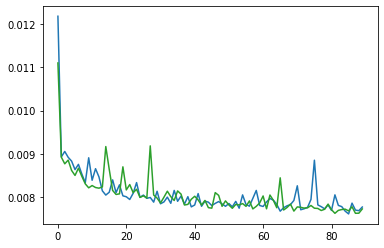

In [13]:
for file_tmp in files_csv:
    print(file_tmp)
    data = pd.read_csv(file_tmp)#['val_Huber'].values[-1]
    plt.plot(data['val_loss'].values[10:])

In [3]:
files_csv

['/users/afengler/data/proj_lan_pipeline/LAN_scripts/data/torch_models/05457dec175011ecadd83cecef057438_lca_no_bias_angle_4_torch_training_history.csv',
 '/users/afengler/data/proj_lan_pipeline/LAN_scripts/data/torch_models/1f496b50127211ecb6943cecef057438_ornstein_torch_training_history.csv',
 '/users/afengler/data/proj_lan_pipeline/LAN_scripts/data/torch_models/d7be901415da11eca6cf3cecef057012_seq2_no_bias_torch_training_history.csv',
 '/users/afengler/data/proj_lan_pipeline/LAN_scripts/data/torch_models/0dbbea1a173711ec93c23cecef057438_race_no_bias_4_torch_training_history.csv',
 '/users/afengler/data/proj_lan_pipeline/LAN_scripts/data/torch_models/7e5bedf21c4011ec97dd3cecef055a96_race_no_bias_4_torch_training_history.csv',
 '/users/afengler/data/proj_lan_pipeline/LAN_scripts/data/torch_models/7c5eb5cc174d11ec9ff33cecef056d26_lca_no_bias_angle_4_torch_training_history.csv',
 '/users/afengler/data/proj_lan_pipeline/LAN_scripts/data/torch_models/a687ad063cbc11ec8bdc3cecef055870_ddm_mi

In [14]:
pickle.load(open('/users/afengler/data/proj_lan_pipeline/LAN_scripts/data/torch_models/db415ca6008311ec8d90a0423f3e9b42_ddm_torch__network_config.pickle', 'rb'))

{'layer_types': ['dense', 'dense', 'dense', 'dense'],
 'layer_sizes': [100, 100, 100, 1],
 'activations': ['tanh', 'tanh', 'tanh', 'linear'],
 'loss': 'huber',
 'callbacks': ['checkpoint', 'earlystopping', 'reducelr'],
 'model_id': 'ddm'}

In [5]:
myl = []
idx = 0
for file_ in files_csv:
    tmp = pd.read_csv(file_)
    myl.append([idx, tmp['val_Huber'].values[-1], tmp['val_MSE'].values[-1]])
    idx += 1

KeyError: 'val_Huber'

In [4]:
# TORCH
import os
import pandas as pd
import pickle
from copy import deepcopy 

# models = ['weibull', 'levy', 'ornstein', 
#           'ddm', 'angle', 
#           'par2_no_bias', 'seq2_no_bias', 'mic2_no_bias',
#           'par2_angle_no_bias', 'seq2_angle_no_bias', 'mic2_angle_no_bias',
#           'par2_weibull_no_bias', 'seq2_weibull_no_bias', 'mic2_weibull_no_bias']

#models = ['lca_no_bias_4', 'lca_no_bias_angle_4', 'race_no_bias_4', 'race_no_bias_angle_4']
models = ['ddm_mic2_adj_no_bias', 'ddm_mic2_adj_weibull_no_bias', 'ddm_mic2_adj_angle_no_bias']

filters_ = models
path_ = '/users/afengler/data/proj_lan_pipeline/LAN_scripts/data/torch_models'
model_wise_pds = []

for filter_ in filters_:
    pds = {}
    models_tmp = deepcopy(models)
    models_tmp.remove(filter_)
    
    for file_ in os.listdir(path_):
        if filter_ in file_ and not (filter_ in models_tmp):
            if 'training_history' in file_:
                pd_tmp = pd.read_csv(path_ + '/' + file_)
                pd_tmp['model_id'] = file_[:file_.find('_')]
                pd_tmp['filename'] = file_
                pd_tmp['path'] = path_ + '/' + file_
                pd_tmp['model_type'] = filter_
                pds[file_[:file_.find('_')]] = pd_tmp


    for m_id in pds.keys():
        for file_ in os.listdir(path_):
            if m_id in file_ and 'network_config' in file_:
                network_config_tmp = pickle.load(open(path_ + '/' + file_, 'rb'))
                pds[m_id]['n_hidden_layers'] = len(network_config_tmp['layer_sizes']) - 1
                pds[m_id]['size_hidden_layers'] = network_config_tmp['layer_sizes'][0]
            #print(network_config_tmp)

    training_dat = pd.concat([pds[m_id] for m_id in pds.keys()]).reset_index(drop = True)

    best_models_pds = []
    for n_h_l in training_dat['n_hidden_layers'].unique():
        for s_h_l in training_dat['size_hidden_layers'].unique():
            training_dat_sub = training_dat.loc[(training_dat['n_hidden_layers'] == n_h_l) & \
                                                (training_dat['size_hidden_layers'] == s_h_l) & \
                                                (training_dat['epoch'] == training_dat['epoch'].max()), :]
            val_loss_min = training_dat_sub['val_loss'].min()
            best_models_pds.append(training_dat_sub.loc[training_dat_sub['val_loss'] == val_loss_min, :])
        
        
    best_models_dat = pd.concat(best_models_pds)
    model_wise_pds.append(best_models_dat)
    
full_dat = pd.concat(model_wise_pds).reset_index(drop = True).drop(['Unnamed: 0'], axis = 1)

In [39]:
# Make dataframe that splits by unique n_hidden layers and unique size hidden layers
# --> Stores min val loss
# --> Stores filename

In [11]:
full_dat.loc[full_dat['model_type'] == 'ddm_mic2_adj_no_bias', :]

,epoch,val_loss,model_id,filename,path,model_type,n_hidden_layers,size_hidden_layers
0,19.0,0.008941,0fc8e5c63cba11eca223a0423f3e9be2,0fc8e5c63cba11eca223a0423f3e9be2_ddm_mic2_adj_...,/users/afengler/data/proj_lan_pipeline/LAN_scr...,ddm_mic2_adj_no_bias,5,120
1,19.0,0.008890,0fc887ac3cba11ec8257ac1f6bfea5a4,0fc887ac3cba11ec8257ac1f6bfea5a4_ddm_mic2_adj_...,/users/afengler/data/proj_lan_pipeline/LAN_scr...,ddm_mic2_adj_no_bias,5,150
2,19.0,0.008891,2f347bbe3cc411eca446a0423f3e9be0,2f347bbe3cc411eca446a0423f3e9be0_ddm_mic2_adj_...,/users/afengler/data/proj_lan_pipeline/LAN_scr...,ddm_mic2_adj_no_bias,5,100
3,19.0,0.008973,1ef2bb043cc311ec9f43a0423f3e9b5e,1ef2bb043cc311ec9f43a0423f3e9b5e_ddm_mic2_adj_...,/users/afengler/data/proj_lan_pipeline/LAN_scr...,ddm_mic2_adj_no_bias,4,120
4,19.0,0.008840,0fc7fa1c3cba11ec9822a0423f39a3e6,0fc7fa1c3cba11ec9822a0423f39a3e6_ddm_mic2_adj_...,/users/afengler/data/proj_lan_pipeline/LAN_scr...,ddm_mic2_adj_no_bias,4,150
5,19.0,0.008776,049de8c23cba11ecb507a0423f3e9a4a,049de8c23cba11ecb507a0423f3e9a4a_ddm_mic2_adj_...,/users/afengler/data/proj_lan_pipeline/LAN_scr...,ddm_mic2_adj_no_bias,4,100
6,19.0,0.008852,0fc7ae363cba11ec82a6a0423f3e9b72,0fc7ae363cba11ec82a6a0423f3e9b72_ddm_mic2_adj_...,/users/afengler/data/proj_lan_pipeline/LAN_scr...,ddm_mic2_adj_no_bias,3,120
7,19.0,0.008881,1ef2a07e3cc311ec89eea0423f3e9b68,1ef2a07e3cc311ec89eea0423f3e9b68_ddm_mic2_adj_...,/users/afengler/data/proj_lan_pipeline/LAN_scr...,ddm_mic2_adj_no_bias,3,150
8,19.0,0.008817,da93ea8c3cc211ec88c6a0423f3e9b42,da93ea8c3cc211ec88c6a0423f3e9b42_ddm_mic2_adj_...,/users/afengler/data/proj_lan_pipeline/LAN_scr...,ddm_mic2_adj_no_bias,3,100


In [12]:
full_dat.loc[full_dat['model_type'] == 'ddm_mic2_adj_no_bias', :].path.values

array(['/users/afengler/data/proj_lan_pipeline/LAN_scripts/data/torch_models/0fc8e5c63cba11eca223a0423f3e9be2_ddm_mic2_adj_no_bias_torch_training_history.csv',
       '/users/afengler/data/proj_lan_pipeline/LAN_scripts/data/torch_models/0fc887ac3cba11ec8257ac1f6bfea5a4_ddm_mic2_adj_no_bias_torch_training_history.csv',
       '/users/afengler/data/proj_lan_pipeline/LAN_scripts/data/torch_models/2f347bbe3cc411eca446a0423f3e9be0_ddm_mic2_adj_no_bias_torch_training_history.csv',
       '/users/afengler/data/proj_lan_pipeline/LAN_scripts/data/torch_models/1ef2bb043cc311ec9f43a0423f3e9b5e_ddm_mic2_adj_no_bias_torch_training_history.csv',
       '/users/afengler/data/proj_lan_pipeline/LAN_scripts/data/torch_models/0fc7fa1c3cba11ec9822a0423f39a3e6_ddm_mic2_adj_no_bias_torch_training_history.csv',
       '/users/afengler/data/proj_lan_pipeline/LAN_scripts/data/torch_models/049de8c23cba11ecb507a0423f3e9a4a_ddm_mic2_adj_no_bias_torch_training_history.csv',
       '/users/afengler/data/proj_lan_pi

In [6]:
full_dat.loc[full_dat['model_type'] == 'ddm_mic2_adj_weibull_no_bias', :]

,epoch,val_loss,model_id,filename,path,model_type,n_hidden_layers,size_hidden_layers
9,19.0,0.002722,1fe1b1603cd611ecab63a0423f3e9a4a,1fe1b1603cd611ecab63a0423f3e9a4a_ddm_mic2_adj_...,/users/afengler/data/proj_lan_pipeline/LAN_scr...,ddm_mic2_adj_weibull_no_bias,3,120
10,19.0,0.002850,139c947a3cd511ec826fa0423f3e9b72,139c947a3cd511ec826fa0423f3e9b72_ddm_mic2_adj_...,/users/afengler/data/proj_lan_pipeline/LAN_scr...,ddm_mic2_adj_weibull_no_bias,3,100
11,19.0,0.002893,db2c830e3cd711ecbd60a0423f3e9be0,db2c830e3cd711ecbd60a0423f3e9be0_ddm_mic2_adj_...,/users/afengler/data/proj_lan_pipeline/LAN_scr...,ddm_mic2_adj_weibull_no_bias,3,150
12,19.0,0.002711,71c11e703ccd11ecae903cecef055870,71c11e703ccd11ecae903cecef055870_ddm_mic2_adj_...,/users/afengler/data/proj_lan_pipeline/LAN_scr...,ddm_mic2_adj_weibull_no_bias,4,120
13,19.0,0.002747,151a6c363ccc11ecbf89a0423f3e9b68,151a6c363ccc11ecbf89a0423f3e9b68_ddm_mic2_adj_...,/users/afengler/data/proj_lan_pipeline/LAN_scr...,ddm_mic2_adj_weibull_no_bias,4,100
14,19.0,0.002664,d947cf623cd711ecbfde3cecef055870,d947cf623cd711ecbfde3cecef055870_ddm_mic2_adj_...,/users/afengler/data/proj_lan_pipeline/LAN_scr...,ddm_mic2_adj_weibull_no_bias,4,150
15,19.0,0.002723,0ae8b8063cce11eca64e3cecef055870,0ae8b8063cce11eca64e3cecef055870_ddm_mic2_adj_...,/users/afengler/data/proj_lan_pipeline/LAN_scr...,ddm_mic2_adj_weibull_no_bias,5,120
16,19.0,0.002713,346370c43ccc11ecbdcaa0423f3e9b5e,346370c43ccc11ecbdcaa0423f3e9b5e_ddm_mic2_adj_...,/users/afengler/data/proj_lan_pipeline/LAN_scr...,ddm_mic2_adj_weibull_no_bias,5,100
17,19.0,0.002761,8fb0dbb43cd711ecaca23cecef05595c,8fb0dbb43cd711ecaca23cecef05595c_ddm_mic2_adj_...,/users/afengler/data/proj_lan_pipeline/LAN_scr...,ddm_mic2_adj_weibull_no_bias,5,150


In [10]:
full_dat.loc[full_dat['model_type'] == 'ddm_mic2_adj_weibull_no_bias', :].path.values

array(['/users/afengler/data/proj_lan_pipeline/LAN_scripts/data/torch_models/1fe1b1603cd611ecab63a0423f3e9a4a_ddm_mic2_adj_weibull_no_bias_torch_training_history.csv',
       '/users/afengler/data/proj_lan_pipeline/LAN_scripts/data/torch_models/139c947a3cd511ec826fa0423f3e9b72_ddm_mic2_adj_weibull_no_bias_torch_training_history.csv',
       '/users/afengler/data/proj_lan_pipeline/LAN_scripts/data/torch_models/db2c830e3cd711ecbd60a0423f3e9be0_ddm_mic2_adj_weibull_no_bias_torch_training_history.csv',
       '/users/afengler/data/proj_lan_pipeline/LAN_scripts/data/torch_models/71c11e703ccd11ecae903cecef055870_ddm_mic2_adj_weibull_no_bias_torch_training_history.csv',
       '/users/afengler/data/proj_lan_pipeline/LAN_scripts/data/torch_models/151a6c363ccc11ecbf89a0423f3e9b68_ddm_mic2_adj_weibull_no_bias_torch_training_history.csv',
       '/users/afengler/data/proj_lan_pipeline/LAN_scripts/data/torch_models/d947cf623cd711ecbfde3cecef055870_ddm_mic2_adj_weibull_no_bias_torch_training_histor

In [13]:
full_dat.loc[full_dat['model_type'] == 'ddm_mic2_adj_angle_no_bias', :]

,epoch,val_loss,model_id,filename,path,model_type,n_hidden_layers,size_hidden_layers
18,19.0,0.002694,89f841103cc511eca78c3cecef055870,89f841103cc511eca78c3cecef055870_ddm_mic2_adj_...,/users/afengler/data/proj_lan_pipeline/LAN_scr...,ddm_mic2_adj_angle_no_bias,5,100
19,19.0,0.002624,67a5331c3cbf11ec9be6a0423f39b436,67a5331c3cbf11ec9be6a0423f39b436_ddm_mic2_adj_...,/users/afengler/data/proj_lan_pipeline/LAN_scr...,ddm_mic2_adj_angle_no_bias,5,120
20,19.0,0.002758,b457b1883ccb11ec9322a0423f3e9b42,b457b1883ccb11ec9322a0423f3e9b42_ddm_mic2_adj_...,/users/afengler/data/proj_lan_pipeline/LAN_scr...,ddm_mic2_adj_angle_no_bias,5,150
21,19.0,0.002740,a0439e1e3cbc11ec9fffa0423f3e9b4e,a0439e1e3cbc11ec9fffa0423f3e9b4e_ddm_mic2_adj_...,/users/afengler/data/proj_lan_pipeline/LAN_scr...,ddm_mic2_adj_angle_no_bias,3,100
22,19.0,0.002701,1bbb0dea3cc511ec8dbd3cecef055870,1bbb0dea3cc511ec8dbd3cecef055870_ddm_mic2_adj_...,/users/afengler/data/proj_lan_pipeline/LAN_scr...,ddm_mic2_adj_angle_no_bias,3,120
23,19.0,0.002569,679e07723cbf11ec8ecf3cecef057a8a,679e07723cbf11ec8ecf3cecef057a8a_ddm_mic2_adj_...,/users/afengler/data/proj_lan_pipeline/LAN_scr...,ddm_mic2_adj_angle_no_bias,3,150
24,19.0,0.002705,122c7ca63cc411eca89b3cecef05595c,122c7ca63cc411eca89b3cecef05595c_ddm_mic2_adj_...,/users/afengler/data/proj_lan_pipeline/LAN_scr...,ddm_mic2_adj_angle_no_bias,4,100
25,19.0,0.002762,a687730e3cbc11ec8a2d3cecef055870,a687730e3cbc11ec8a2d3cecef055870_ddm_mic2_adj_...,/users/afengler/data/proj_lan_pipeline/LAN_scr...,ddm_mic2_adj_angle_no_bias,4,120
26,19.0,0.002636,620893c03ccb11eca03fac1f6bfea5a4,620893c03ccb11eca03fac1f6bfea5a4_ddm_mic2_adj_...,/users/afengler/data/proj_lan_pipeline/LAN_scr...,ddm_mic2_adj_angle_no_bias,4,150


In [ ]:
full_dat.loc[full_dat['model_type'] == 'ddm_mic2_adj_angle_no_bias', :].path.values

In [93]:
full_dat.loc[full_dat['model_type'] == 'par2_angle_no_bias', :]['path'].values

array(['/users/afengler/data/proj_lan_pipeline/LAN_scripts/data/torch_models/625fb06e160c11ecbbe73cecef057012_mic2_angle_no_bias_torch_training_history.csv',
       '/users/afengler/data/proj_lan_pipeline/LAN_scripts/data/torch_models/08c3c268160f11eca45f3cecef057012_mic2_angle_no_bias_torch_training_history.csv',
       '/users/afengler/data/proj_lan_pipeline/LAN_scripts/data/torch_models/5a2ad60e160111ec9cb53cecef056d26_mic2_angle_no_bias_torch_training_history.csv',
       '/users/afengler/data/proj_lan_pipeline/LAN_scripts/data/torch_models/ae67e6c6160111ecb0183cecef056d26_mic2_angle_no_bias_torch_training_history.csv',
       '/users/afengler/data/proj_lan_pipeline/LAN_scripts/data/torch_models/215d72b6160e11ecb7463cecef056d26_mic2_angle_no_bias_torch_training_history.csv',
       '/users/afengler/data/proj_lan_pipeline/LAN_scripts/data/torch_models/caf248a0160011eca3b23cecef057012_mic2_angle_no_bias_torch_training_history.csv',
       '/users/afengler/data/proj_lan_pipeline/LAN_s

In [89]:
74ca5d6c161b11ec9ebb3cecef056d26

NameError: name 'c611f4ca15dd11ec89543cecef056d26' is not defined

In [30]:
training_data['val_loss'] == val_loss_min

NameError: name 'training_data' is not defined

In [ ]:
os